# Wavefield Simulations Using SPECFEM
## Notebook 2: Forward Simulations

- Here we build upon material learned in Notebook 1
- This notebook allows Users to play around with their own SPECFEM2D homogeneous halfspace example in an exercise
- 
- **Objective:** Familiarize Users with setting `SOURCE` and `STATION` attributes, adjusting velocity model parameters, and assessing simulation results.
- These instructions can optionally be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  

-----------

**Relevant Links:** 
- Original Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2024-5-21_scoped_uw/2_forward_simulations.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


------
## 1) Set Up a SPECFEM Working Directory

- It is often desireable to run SPECFEM outside of the cloned repository, in order to keep files and outputs manageable  
- The trick here is that SPECFEM **only** requires 3 components for a sucessful simulation:
  - `bin/`, 
  - `DATA/`, and
  - `OUTPUT_FILES/`  

In [1]:
# Python packages required for this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Create the correct dir. and move there
##! mkdir -p /home/scoped/work/specfem2d_workdir
##%cd /home/scoped/work/specfem2d_workdir

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s ../../../specfem2d/bin .
! cp -r ../../../specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

! ls

2_forward_simulations.ipynb OUTPUT_FILES
DATA                        bin


----------
## 2) Experimental Setup: Tape et al. 2007 Example Problem

- We will be working with an Example problem from the [Tape et al. 2007 GJI publication](https://academic.oup.com/gji/article/168/3/1105/929373)
- [GitHub repository location of the example problem](https://github.com/geodynamics/specfem2d/tree/devel/EXAMPLES/Tape2007)
- This example pre-defines two models (homogeneous halfspace, checkerboard), multiple (25) seismic sources, and multiple (132) stations  
- In this section we will use the homogeneous halfspace model  


In [3]:
! ls DATA/

Par_file_Tape2007_132rec_checker SOURCE_014
Par_file_Tape2007_onerec         SOURCE_015
SOURCE_001                       SOURCE_016
SOURCE_002                       SOURCE_017
SOURCE_003                       SOURCE_018
SOURCE_004                       SOURCE_019
SOURCE_005                       SOURCE_020
SOURCE_006                       SOURCE_021
SOURCE_007                       SOURCE_022
SOURCE_008                       SOURCE_023
SOURCE_009                       SOURCE_024
SOURCE_010                       SOURCE_025
SOURCE_011                       STATIONS_checker
SOURCE_012                       interfaces_Tape2007.dat
SOURCE_013                       model_velocity.dat_checker


#### DATA/ Directory
- `Par_file` for a homogeneous halfspace model in `Par_file_Tape2007_onerec`
- `Par_file` for a checkerboard model in `Par_file_Tape2007_132rec_checker`
- `Mesh` files in: *interfaces_Tape2007.dat* and the `Par_file_*`
- `Model` files in: *model_velocity.dat_checker*
- `Source` files in: the 25 *SOURCE_???* files
- `Stations`: in the *STATIONS_checker* file

### 2a) The Homogeneous Halfspace Model

- The homogeneous halfspace model in this example is defined internally, in the `Par_file`
- A homogeneous halfspace defines a single set of properties for the entire domain  
- We can also use the utility `seisflows sempar velocity_model` command to look at model values  

In [4]:
# Bash commands to look at the Par_file
! head -287 DATA/Par_file_Tape2007_onerec | tail -16
! echo "..."

# SeisFlows utility function to look at the Par_file
! seisflows sempar -P DATA/Par_file_Tape2007_onerec velocity_model

#-----------------------------------------------------------

# material properties
# number of model materials
nbmodels                        = 1
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   electromagnetic:       model_number 4 mu0 e0 e11(e0) e33(e0) sig11 sig33 Qe11 Qe33 Qs11 Qs33 0 0 0
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs

#### Understanding the Velocity Model 
According to the `Par_file` comments, the model parameter values represent the following:  

```bash
model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0
1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
```

- The homogeneous halfspace model defines a region with P-wave velocity $V_p=5.8$km/s and S-wave velocity $V_s=3.5$km/s.
- The halfspace is also defined by density and attenuation
- We can understand the structure of the mesh by looking at the `Par_file` and the `interfaces_Tape2007.dat` file. 

In [5]:
# Look at Mesh parameters to view the size of the domain
! head -306 DATA/Par_file_Tape2007_onerec | tail -n 15

#       utils/attenuation/conversion_from_Qkappa_Qmu_to_Qp_Qs_from_Dahlen_Tromp_959_960.f90.
1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0

# file containing interfaces for internal mesh
interfacesfile                  = interfaces_Tape2007.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 480000.d0      # abscissa of right side of the model
nx                              = 40             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .true.


In [6]:
# Look at interface parameters 
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


#### Understanding the Mesh parameters

- From the files above, we can see that the X and Z dimensions of our mesh range from 0 to 480000.0m
- Each dimension is separated into 40 elements (defined by `nxmin`, `nxmax` etc. in the `Par_file` and defined by the layer numbers in the interfaces file)  
- That means each spectral element in our 2D mesh spans: 480000m / 40 elements = 12000m / element  (or 12km / element)
- Also note that above we previously learned that the $V_s$ model has a homogeneous value of 3.5 km/s

#### Visualizing the Model
We can make a simple plot using Matplotlib to illustrate what our mesh might look like

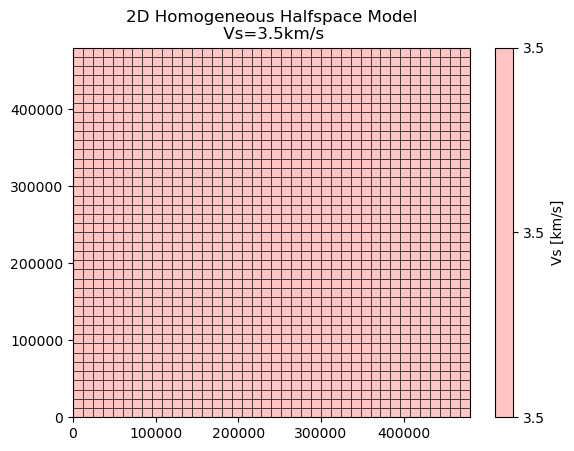

In [7]:
def plot_homogeneous_halfspace():
    """Plots a representation of the SPECFEM2D homogeneous halfspace model"""
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480001, 4000)
    z = np.arange(0, 480001, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

# Plot grid lines representing each of the spectral elements
for i in range(12000, 480000, 12000):
    plt.axvline(i, c="k", lw=0.5)
    plt.axhline(i, c="k", lw=0.5)

### 2b) Visualizing Source-Receiver Geometry

- We can similarly plot the SOURCES and STATIONS available to see what the experiemental setup looks like  

Text(0.5, 1.0, 'SOURCE-RECEIVER GEOMETRY')

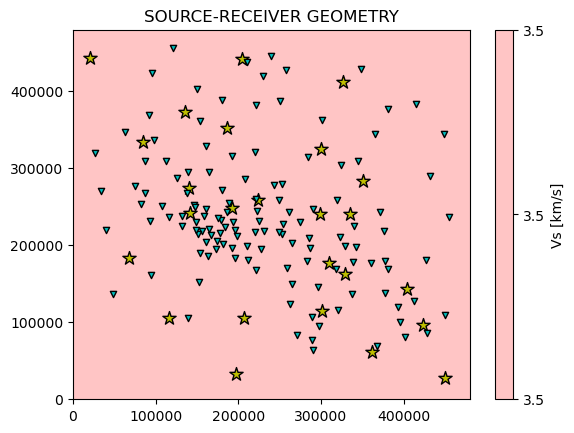

In [8]:
# Grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

# Grab coordinates from each SOURCE file
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)
    
# Plot SOURCES and STATIONS together. Annotate names
plot_homogeneous_halfspace()
plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=20, edgecolor="k")
plt.title("SOURCE-RECEIVER GEOMETRY")

Text(0.5, 1.0, 'SOURCES; N=25')

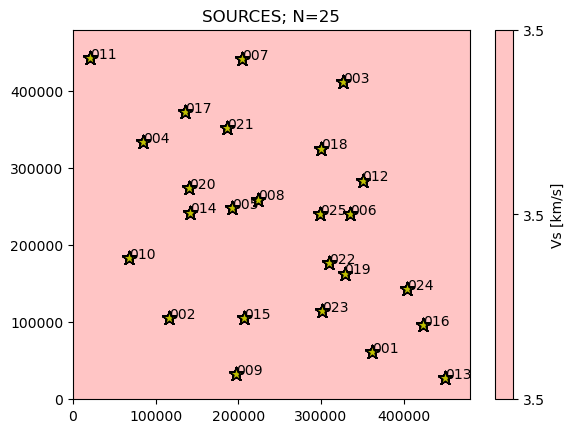

In [9]:
# Plot SOURCES next to source names
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
    plt.text(x, z, f"{i+1:0>3}")  # SOURCE numbering starts at 1
plt.title(f"SOURCES; N={len(ev_x)}")

Text(0.5, 1.0, 'STATIONS; N=132')

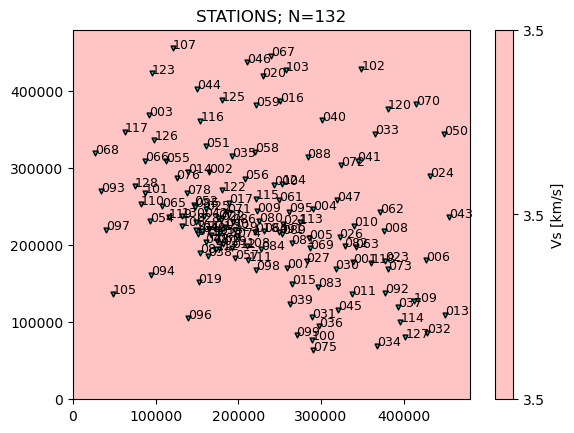

In [10]:
# Plot STATIONS with their names
# Because STATIONS are so close, numbers will be jumbled.
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=12, edgecolor="k")
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title(f"STATIONS; N={len(sta_x)}")

- Upside-down blue triangles represent the 132 receivers in this example
- The 25 yellow stars are the sources. 

----------
## 3) Running SPECFEM2D

- Before we run the example, we need to do some organizational bookkeeping  
- We will choose ONE of our source files to act as our source
- We will choose ONE station to act as our station file  

### 3a) Choosing a Source file

- SPECFEM2D will look for a file named `SOURCE` in the *DATA/* directory to define its source

In [11]:
# Choose SOURCE_001 as our SOURCE File
! cp -f DATA/SOURCE_001 DATA/SOURCE

# > Make sure that the SOURCE name printed below matches choice
! head -1 DATA/SOURCE

## Source 1


### 3b) Choosing Stations

- SPECFEM2D will look for a file named `STATIONS` in the *DATA/* directory to define its stations
- The `STATIONS_checker` file defines 132 different station locations, we only want **one**  
- *Remember*: Individual synthetic seismograms simply extract the simulated wavefield at a location, i.e., computational expense is not tied to the number of stations. 

In [12]:
# Write out a NEW stations file by choosing station numbers
! head -1 DATA/STATIONS_checker > DATA/STATIONS
! cat DATA/STATIONS

S000000 AA 2.43610e+05 2.78904e+05 0.0 0.0


### 3c) Setting up the `Par_file`

- SPECFEM2D will look for a file called `Par_file` in the *DATA/* directory to set its parameters
- We will copy over the `Par_file_Tape2007_onerec` to define our parameter file  
- We need to change a few key parameters in the `Par_file` to run SPECFEM2D with desired behavior    
- We use the `seisflows sempar` command to make the changes but this can be done with a text editor, Bash etc.  

In [13]:
# Copy in the Example parameter file
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Set some necessary parameters for later in the Par_file
##! seisflows sempar -P DATA/Par_file nproc 4 # not needed for serial code
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

use_existing_STATIONS: .false. -> .true.


#### Understanding Parameter Changes

`NPROC`: Sets the number of MPI processors to partition the mesh and run the simulation with. This **must** match the value following `-n` in the MPI      
`use_existing_STATIONS`: Use the STATIONS file we created, as opposed to the `Par_file` definition of stations  

### 3d) Run SPECFEM

- Now that we have set the `Par_file`, the `SOURCE` and `STATIONS` file, we are able to run `xmeshfem2D` and `xspecfem2D` to run our forward simulation.
- We use 4 MPI processes to run this homogeneous halfspace simulation
- We expect only **one** synthetic seismogram to be output from this simulation  

In [14]:
# Ensures we're running with a clean OUTPUT directory
! rm -rf OUTPUT_FILES
! mkdir OUTPUT_FILES
# parallel run
##! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem.txt
##! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt
# serial run
! bin/xmeshfem2D > OUTPUT_FILES/output_meshfem.txt
! bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

! tail OUTPUT_FILES/output_solver.txt

 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 13 - 02 - 2025                                 T i m e  : 11:35:14
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


### 3e) Examine Output Files

- Let's confirm that we have created **one** displacement seismogram
- Then we'll look at the forward simulation figures to see if things make sense


In [15]:
! ls OUTPUT_FILES/
! echo
! ls OUTPUT_FILES/*.semd

AA.S000000.BXY.semd
Database00000.bin
for_information_SOURCE_actually_used
for_information_STATIONS_actually_used
forward_image000000005.jpg
forward_image000000200.jpg
forward_image000000400.jpg
forward_image000000600.jpg
forward_image000000800.jpg
forward_image000001000.jpg
forward_image000001200.jpg
forward_image000001400.jpg
forward_image000001600.jpg
forward_image000001800.jpg
forward_image000002000.jpg
forward_image000002200.jpg
forward_image000002400.jpg
forward_image000002600.jpg
forward_image000002800.jpg
forward_image000003000.jpg
forward_image000003200.jpg
forward_image000003400.jpg
forward_image000003600.jpg
forward_image000003800.jpg
forward_image000004000.jpg
forward_image000004200.jpg
forward_image000004400.jpg
forward_image000004600.jpg
forward_image000004800.jpg
forward_image000005000.jpg
mesh00000_rho.vtk
mesh00000_vp.vtk
mesh00000_vs.vtk
mesh_materials.vtk
mesh_partition_number.vtk
output_list_stations.txt
output_meshfem.txt
output_solver.txt
plot_points_per_wavelengt

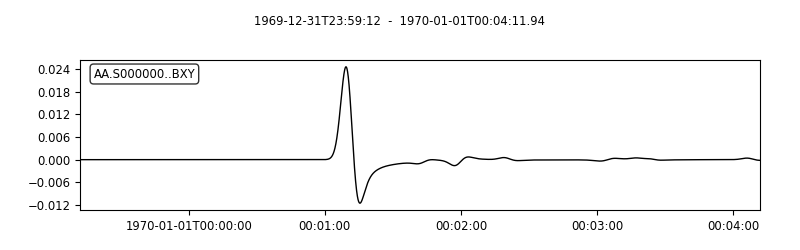

In [16]:
# We can use SeisFlows to plot our waveform
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --savefig AA.S000000.BXY.png
Image("AA.S000000.BXY.png")

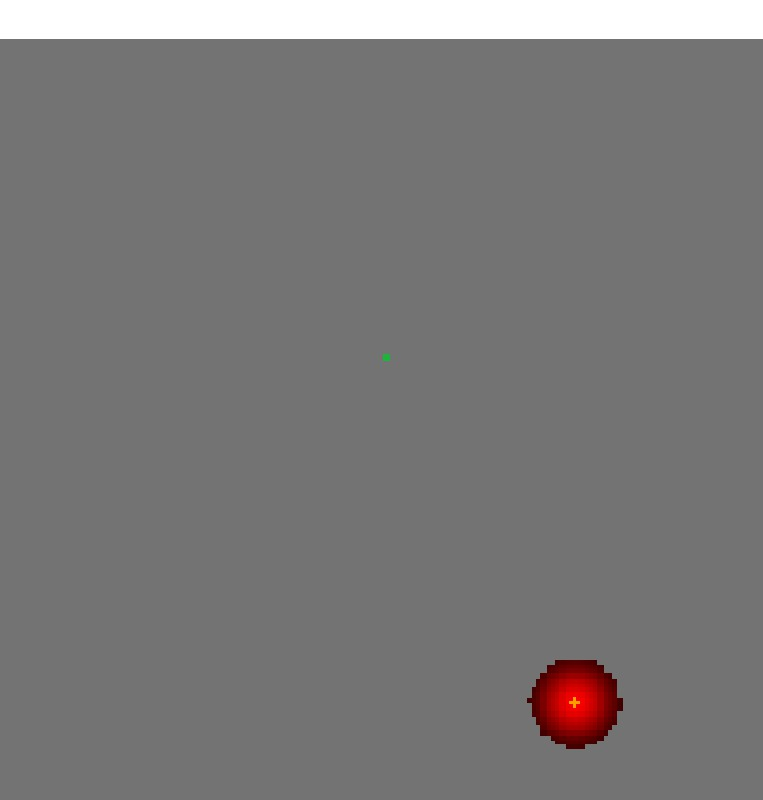

In [17]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000000800.jpg")

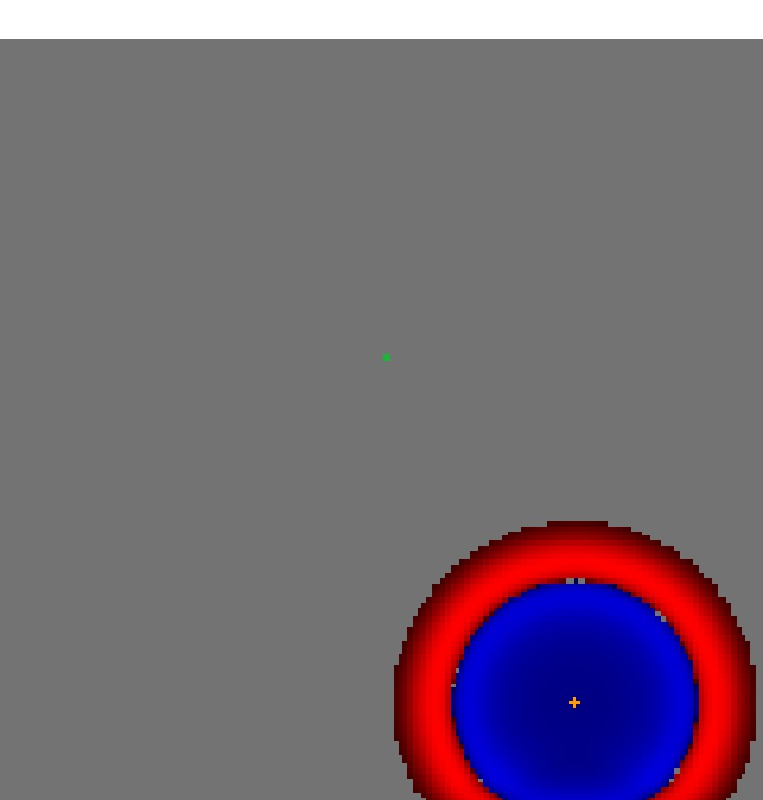

In [18]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000001200.jpg")

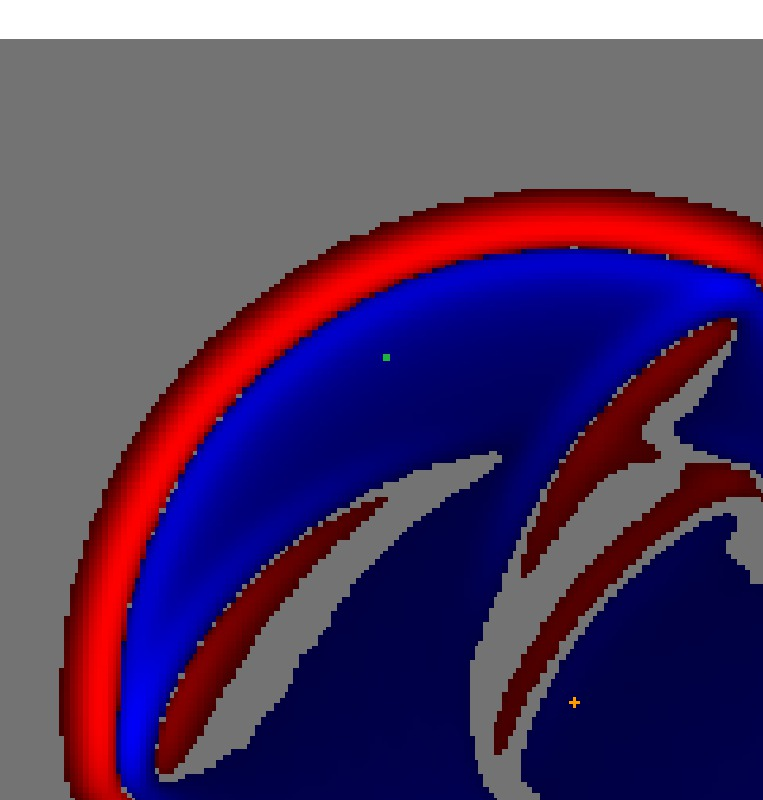

In [19]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000002200.jpg")

## Generate an Animation of the Wavefield

We use `ffmpeg` to generate a video file in `mp4` format.

In [1]:
! /Applications/ffmpeg -framerate 9 -pattern_type glob -i './OUTPUT_FILES/forward_image*.jpg'  -vf 'crop=trunc(iw/2)*2:trunc(ih/2)*2' wavefield.mp4

ffmpeg version 7.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.3)
-disable-ffplay: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libharfbuzz --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-c

### Display the video

Using an html snippet, we can display the video directly in the notebook.

See also the animation tutorials.

In [3]:
%%html
<video controls loop width="640" height="480">
  <source src="./wavefield.mp4" type="video/mp4" />

---------------------
## 4) Forward Simulation Exercise

- Participants will now be asked to edit simulation parameters to run their own simulation  
- Some things that you are asked to try include:
    1) Change the parameters of the homogeneous halfspace model defined in the `Par_file` 
    2) Define a *STATIONS* file with a uniform grid of stations to record synthetics throughout the domain
    3) Choose a different source, or increase the energy released by the source (using the moment tensor)
    4) Re-run the mesher and solver to get new synthetics
    5) Analyze the new results in comparison to the old results

See the Exercise1 notebook.

#### Task 1: Edit the Velocity Model
- Change the velocity model parameters in the homogeneous halfspace model
- Remember, the velocity model is defined in the `Par_file`
- Try **increasing** seismic velocity (Vp and Vs) by 10\%
- You can use Python, Bash, `seisflows sempar` or a Text Editor to do this  

#### Task 2: Create a New STATIONS File
- Define a STATIONS file that covers the **entire** domain with a uniform grid spacing of: 
    - dx = 80km 
    - dz = 80km
    - x_start = 0km
    - z_start = 0km
- **Or** Create your own station configuration. Some examples: spiral, concentric rings, dense linear array (like DAS)
- You can find the X and Z dimensions of the mesh in the `Par_file` and the `interfaces` file, respectively  
- Use Python/NumPy to loop values, or simply write out a text file manually with the text editor
- *Look* at *DATA/STATIONS_checker* for an example of how the file should look
- **NOTE**: The last two columns (burial, elevation) can be set to 0  

#### Task 3: Choose and edit a SOURCE file

- Use one of the original sources as a template for your new source
- **Set** the location of your source in the exact **middle** of your domain (or a location of your choice!)  
- **Set** the moment tensor (Mxx, Mzz, Mxz) of your event to make this an **explosive** source (or a mechanism of your choice!)  
- Don't change the scaling on the moment tensor  

#### Task 4: Run the Solver and Analyze Outputs

- Run the mesher and solver with your new experimental setup and 4 MPI processes  
- **Remember** to tell SPECFEM to use your `STATIONS` file and not its internal representation of stations
- **Remember** to tell SPECFEM that we want to run this with 4 processors
- Look at the source images to see if your explosion makes sense
- Plot waveforms output from your gridded stations